In [22]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [23]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/133272
Connected. Call `.close()` to terminate connection gracefully.


In [24]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=4)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=4,
                                  description="Read from wine dataset",
                                  labels=["quality"],
                                  query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/133272/fs/133191/fv/wine/version/4


In [25]:
# linear regression model possible to use for version 3 of the feature group
# but it yields a lower accuracy than the gradient boosting classifier (0.51 instead of 0.66)
# resource: https://www.kaggle.com/code/rohanchopade/wine-quality-prediciton-using-linear-regression

In [27]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

k_neighbors = range(2 , 11 , 2)
Training_acc = []
Testing_acc = []

# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
for i in k_neighbors:
    
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train)
    Training_acc.append(model.score(X_train, y_train))
    Testing_acc.append(model.score(X_test, y_test))
    
print(f'Training accuracy: f{Training_acc}')
print(f'Testing accuracy: f{Testing_acc}')

Finished: Reading data from Hopsworks, using ArrowFlight (16.00s) 


Training accuracy: f[0.8293201133144475, 0.7724268177525968, 0.7507082152974505, 0.7431539187913125, 0.7351274787535411]
Testing accuracy: f[0.603399433427762, 0.6373937677053825, 0.6298394711992445, 0.6336166194523135, 0.6421152030217187]


In [28]:
clf = GradientBoostingClassifier(random_state= 42)

params = {
    'n_estimators': range(25 , 125 , 25),
    'max_depth': range(3 , 45 , 10)
}
params

gbc = GridSearchCV(
    clf,
    param_grid= params,
    cv= 5,
    n_jobs=-1,
    verbose=1
)
gbc

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 45, 10),
                         'n_estimators': range(25, 125, 25)},
             verbose=1)

In [29]:
gbc.fit(X_train , y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/matteocirca/opt/anaconda3/envs/smldl/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matteocirca/opt/anaconda3/envs/smldl/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matteocirca/opt/anaconda3/envs/smldl/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matteocirca/opt/anaconda3/envs/smldl/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A 

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 45, 10),
                         'n_estimators': range(25, 125, 25)},
             verbose=1)

In [30]:
cv_results = pd.DataFrame(gbc.cv_results_)
cv_results.sort_values(by= 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.553117,0.016704,0.006525,0.005961,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.786557,0.769776,0.750885,0.765053,0.750885,0.764631,0.013306,1
2,0.426532,0.030586,0.002675,0.000035,3,75,"{'max_depth': 3, 'n_estimators': 75}",0.784198,0.765053,0.747344,0.767414,0.747344,0.762271,0.013861,2
1,0.331215,0.026253,0.002848,0.000276,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.780660,0.763872,0.752066,0.762692,0.744982,0.760855,0.012115,3
7,4.637247,0.074732,0.012831,0.003196,13,100,"{'max_depth': 13, 'n_estimators': 100}",0.768868,0.761511,0.746163,0.739079,0.737898,0.750704,0.012381,4
0,0.190976,0.012132,0.002971,0.001210,3,25,"{'max_depth': 3, 'n_estimators': 25}",0.765330,0.753247,0.735537,0.753247,0.733176,0.748107,0.012086,5
6,3.707761,0.090031,0.012639,0.003259,13,75,"{'max_depth': 13, 'n_estimators': 75}",0.770047,0.759150,0.740260,0.723731,0.736718,0.745981,0.016530,6
5,2.372362,0.034465,0.012618,0.005572,13,50,"{'max_depth': 13, 'n_estimators': 50}",0.764151,0.746163,0.731995,0.715466,0.729634,0.737482,0.016510,7
4,1.063525,0.029645,0.003667,0.000041,13,25,"{'max_depth': 13, 'n_estimators': 25}",0.759434,0.730815,0.716647,0.706021,0.726092,0.727802,0.017952,8
17,1.637689,0.028034,0.004557,0.001085,43,50,"{'max_depth': 43, 'n_estimators': 50}",0.732311,0.710744,0.672963,0.658796,0.676505,0.690264,0.027079,9
13,1.636248,0.028478,0.004896,0.001903,33,50,"{'max_depth': 33, 'n_estimators': 50}",0.732311,0.710744,0.672963,0.658796,0.676505,0.690264,0.027079,9


In [31]:
gbc.best_params_

{'max_depth': 3, 'n_estimators': 100}

In [32]:
X_train

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
0,0,7.8,0.25,0.37,1.0,0.043,10.0,80.0,0.99128,3.08,0.38,11.4
1,1,7.8,0.60,0.14,2.4,0.086,3.0,15.0,0.99750,3.42,0.60,10.8
2,1,7.3,0.73,0.24,1.9,0.108,18.0,102.0,0.99670,3.26,0.59,9.3
3,0,5.9,0.29,0.32,1.4,0.022,17.0,47.0,0.98990,3.35,0.35,11.5
4,1,7.2,0.58,0.54,2.1,0.114,3.0,9.0,0.99719,3.33,0.57,10.3
...,...,...,...,...,...,...,...,...,...,...,...,...
5288,0,7.2,0.15,0.33,1.1,0.027,16.0,63.0,0.99370,3.37,0.40,9.9
5290,1,11.9,0.38,0.49,2.7,0.098,12.0,42.0,1.00040,3.16,0.61,10.3
5291,0,5.6,0.18,0.31,1.5,0.038,16.0,84.0,0.99240,3.34,0.58,10.1
5293,0,10.0,0.91,0.42,1.6,0.056,34.0,181.0,0.99680,3.11,0.46,10.0


In [33]:
y_train

,quality
0,bad
1,good
2,bad
3,good
4,bad
...,...
5288,bad
5290,bad
5291,good
5293,bad


In [34]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [35]:
print(metrics)

{'bad': {'precision': 0.5326370757180157, 'recall': 0.504950495049505, 'f1-score': 0.5184243964421855, 'support': 404}, 'good': {'precision': 0.7041420118343196, 'recall': 0.7267175572519083, 'f1-score': 0.7152516904583021, 'support': 655}, 'accuracy': 0.6421152030217187, 'macro avg': {'precision': 0.6183895437761676, 'recall': 0.6158340261507067, 'f1-score': 0.6168380434502438, 'support': 1059}, 'weighted avg': {'precision': 0.6387142552800356, 'recall': 0.6421152030217187, 'f1-score': 0.6401636576136268, 'support': 1059}}


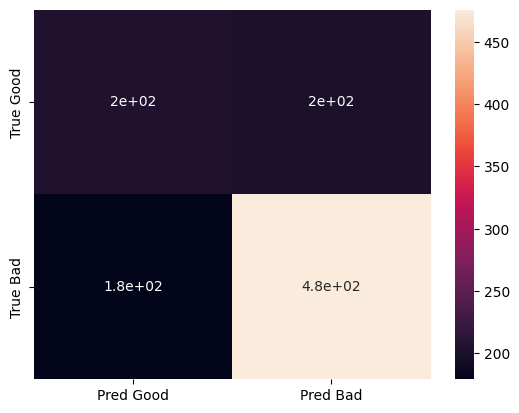

In [36]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Good', 'True Bad'],
                     ['Pred Good', 'Pred Bad'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [37]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
iris_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
iris_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.97s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/133272/models/wine_model/2


Model(name: 'wine_model', version: 2)